In [ ]:
# pip install statsmodels==0.13.2

In [ ]:
# pip install pmdarima

# Import dependencies

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns  
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.datasets import load_wineind
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict


In [ ]:
def plot(data):
  plt.figure(figsize=(15,4))
  plt.plot(data, color='tab:red')
  plt.gca().set(title="USA Suicides (*U03,X60-X84,Y87.0)", xlabel="Year", ylabel="Suicide rate")
  plt.grid()
  plt.show()

def stationarity_test2(data):
  stationarity_test = adfuller(data, autolag='AIC')
  dfoutput = pd.Series(stationarity_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in stationarity_test[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (15,4))
    plt.xlabel('Year')
    plt.ylabel('Suicide rate')    
    plt.title('USA Suicides (*U03,X60-X84,Y87.0)')
    plt.plot(timeseries, color= 'tab:blue', label= 'Rate')
    plt.plot(rolling_mean, color= 'tab:green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'tab:red', label= 'Rolling Std')   
    plt.grid()
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries['Deaths'])
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

def plot_pred_(fit_m, start=15, end=251):
    pred = fit_m.get_prediction(start = start, end = end).summary_frame()
    fitted = pd.DataFrame(pred["mean"])
    lower = pd.DataFrame(pred["mean_ci_lower"])
    upper = pd.DataFrame(pred["mean_ci_upper"])
    plt.figure(figsize=(15,4))
    plt.fill_between(lower.index, 
                    lower["mean_ci_lower"], 
                    upper["mean_ci_upper"], 
                    color='k', alpha=.15, label="95% CI")
    plt.plot(X_train, color='tab:red', label="Original")
    plt.plot(fitted, color='tab:blue', label="Predicted")
    plt.gca().set(title="Forecast - USA Suicides (*U03,X60-X84,Y87.0)", xlabel="Year", ylabel="Suicide rate")
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

def de_diff(X_train, X_no_season, X_train_res, X_train_res_prev=None, d=1, D=12):
    
    main_series = X_train_res
    if d>1 and X_train_res_prev is not None:
        for j in range(1, d):
            recover_trend = pd.concat([X_train_res_prev[-j].iloc[[0]], main_series], axis = 0)
            for i in range(1, len(recover_trend)):
                recover_trend["Deaths"][i] = recover_trend["Deaths"][i-1] + main_series["Deaths"][i-1]
            
            main_series = recover_trend.copy()

    recover_season = pd.concat([X_no_season.iloc[[0]], main_series], axis = 0)
    for i in range(1, len(main_series)):
        recover_season["Deaths"][i] = recover_season["Deaths"][i-1] + main_series["Deaths"][i-1]
    
    recover = pd.concat([X_train.iloc[0:D, :], recover_season], axis = 0)
    for i in range(D, len(recover)):
        recover["Deaths"][i] = recover["Deaths"][i-D] + recover_season["Deaths"][i-D]
    
    return recover
    
def ARMA_grid_search(data, p_max: int, q_max:int):
    
    """
    Search the best values of p and q to representent
    the time series as an ARMA(p,q) model.
    
    Params
    ------
    
    data (pandas.DataFrame): the datatset
    p_max (int): the maximum value of p to test (included)
    q_max (int): the maximum value of q to test (included)
    
    Returns
    -------
    
    best_model (int, int): the best couple (p,q)
    best_aic (float): the AIC value for this (p,q) couple
    """
    
    best_aicc = float("inf")
    best_bic =float("inf")
    best_model_aicc = (-1, -1)
    best_model_bic = (-1, -1)
    
    for p in range(p_max + 1):
        for q in range(q_max + 1):
            
            if (p, q) != (0, 0): # ARMA(0, 0) undefined
            
                model = ARIMA(data, order = (p, 0, q), trend="n")

                try:

                    results = model.fit(method_kwargs={"warn_convergence": False})
                    aicc = results.aicc
                    bic = results.bic

                    print(f"ARMA({p},{q}): AICC={aicc}, BIC={bic}")

                    if aicc < best_aicc:
                        best_model_aicc = (p, q)
                        best_aicc = aicc
                    
                    if bic < best_bic:
                        best_model_bic = (p, q)
                        best_bic = bic

                except: print(f"ARMA({p},{q}): intractable")
                
    return best_model_aicc, best_aicc, best_model_bic, best_bic  

# Load the dataset

https://fred.stlouisfed.org/series/POPTHM population

In [ ]:
pop = pd.read_csv('./POPTHM.csv',sep=',')
pop['DATE'] = pd.to_datetime(pop['DATE'], infer_datetime_format = True)
pop.rename(columns = {"DATE": "Date", "POPTHM":"Population"}, inplace = True)
pop.set_index('Date', inplace=True)
pop.index = pd.DatetimeIndex(pop.index.values,
                            freq=pop.index.inferred_freq)

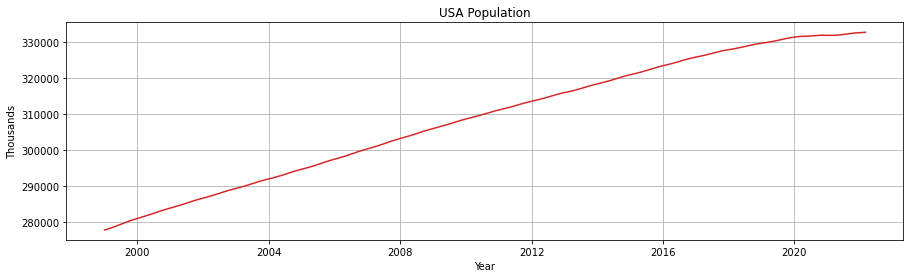

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(pop, color='tab:red')
plt.gca().set(title="USA Population", xlabel="Year", ylabel="Thousands")
plt.grid()
plt.show()

In [ ]:
pop.head()

,Population
1999-01-01,277891.0
1999-02-01,278095.0
1999-03-01,278324.0
1999-04-01,278584.0
1999-05-01,278859.0


In [ ]:
# Load from a CSV file
X_train = pd.read_csv('./USA_suicide_1999-2020.csv',sep=';')

In [ ]:
# Rename the columns and change type
X_train['Month'] = pd.to_datetime(X_train['Month'], infer_datetime_format = True)
X_train.rename(columns = {"Month": "Date"}, inplace = True)
X_train.set_index('Date', inplace=True)

In [ ]:
freq = X_train.index.inferred_freq

In [ ]:
X_train.index = pd.DatetimeIndex(X_train.index.values,
                               freq=X_train.index.inferred_freq)

In [ ]:
X_train.tail()

,Deaths
2020-08-01,4040
2020-09-01,3908
2020-10-01,3781
2020-11-01,3704
2020-12-01,3559


In [ ]:
pop_red = pop.loc[[str(date) for date in pd.date_range(start="1999-01-01", end="2020-12-01", freq="MS").date]]

In [ ]:
X_train["Deaths"] = (X_train["Deaths"]/pop_red["Population"])*100

Now that we got acquainted with the dataset, let us visualize the evolution of the number of passengers throughout the time to see if we can detect a trend or a seasonali

# Visualize data and test stationarity

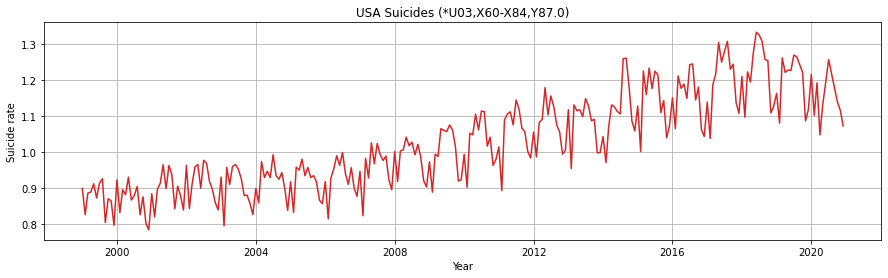

In [ ]:
plot(X_train)

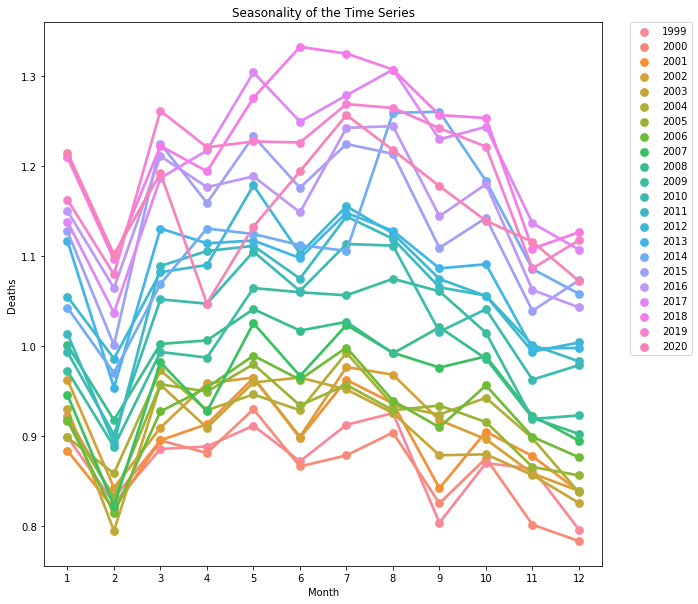

In [ ]:
df_temp = X_train.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month
# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Deaths',hue='Year',data=df_temp)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

We can clearly see that the time series is not statoriary because we have an increasing trend, and therefore not constant mean. Also we see some seasonality as we would expect from yearly beheviours.

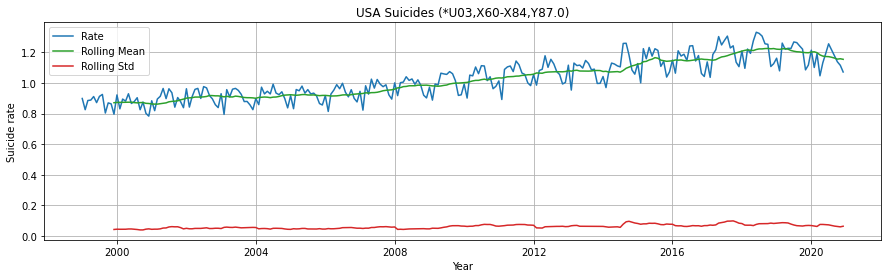

Results of Dickey-Fuller Test
Test Statistic                  -0.877546
p-value                          0.795277
#Lags Used                      12.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [ ]:
stationarity_test(X_train)

Calculating corresponding moving average and std with a period of 12 months (1 year) we can see that we have a clear trend. We also see that we have a p-value of 0.82 which indicate us that the series is not stationary. We are going to apply some methods in order to remove the trend and seasonality to make our time series stationary.

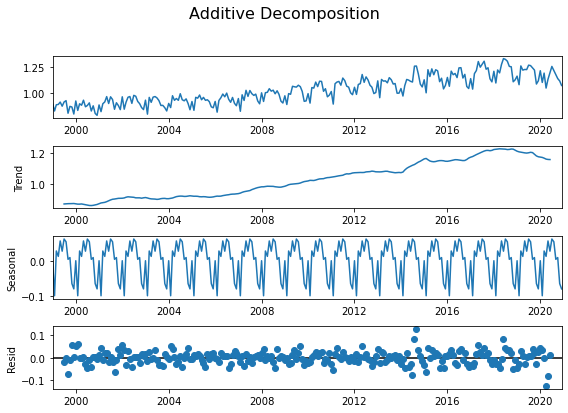

In [ ]:
additive_decomposition = seasonal_decompose(X_train, model='additive',period=12)
# Plot
plt.rcParams.update({'figure.figsize': (8,6)})
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

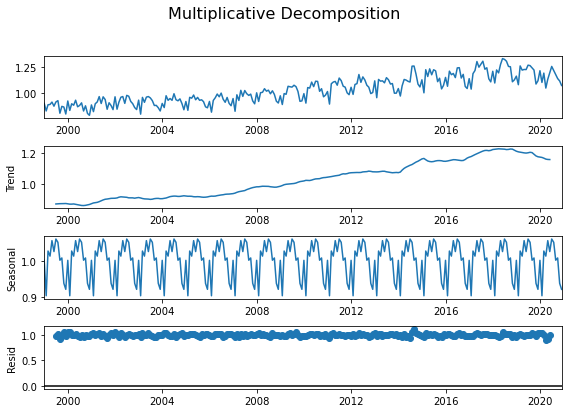

In [ ]:
multiplicative_decomposition = seasonal_decompose(X_train, model='multiplicative',period=12)
# Plot
plt.rcParams.update({'figure.figsize': (8,6)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
X_train_res_mul = multiplicative_decomposition.resid
X_train_res_mul.dropna(inplace=True)
X_train_res_mul = X_train_res_mul.to_frame()
X_train_res_mul.columns = ['Deaths']

In [ ]:
stationarity_test2(X_train_res_mul['Deaths'])

Test Statistic                -8.176264e+00
p-value                        8.361186e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


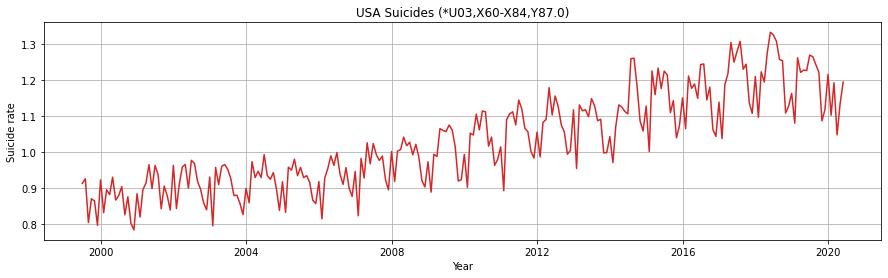

In [ ]:
plot(multiplicative_decomposition.resid*multiplicative_decomposition.seasonal*multiplicative_decomposition.trend)

In [ ]:
X_train_res_add = additive_decomposition.resid
X_train_res_add.dropna(inplace=True)
X_train_res_add = X_train_res_add.to_frame()
X_train_res_add.columns = ['Deaths']

In [ ]:
stationarity_test2(X_train_res_add['Deaths'])

Test Statistic                -8.448946e+00
p-value                        1.682756e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


We find that the additive model is better than the multiplicative one (lower p-value) so we are going to use it. There is no need to use the log scale then.

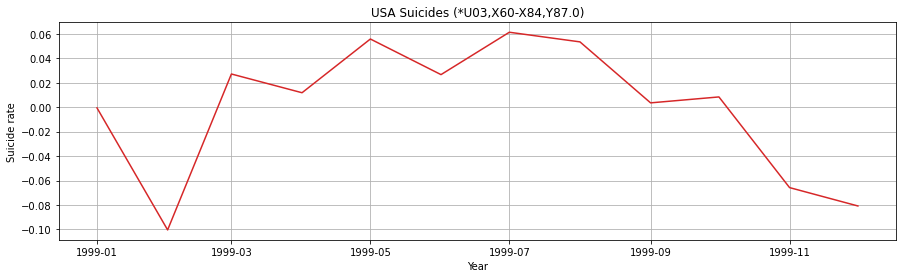

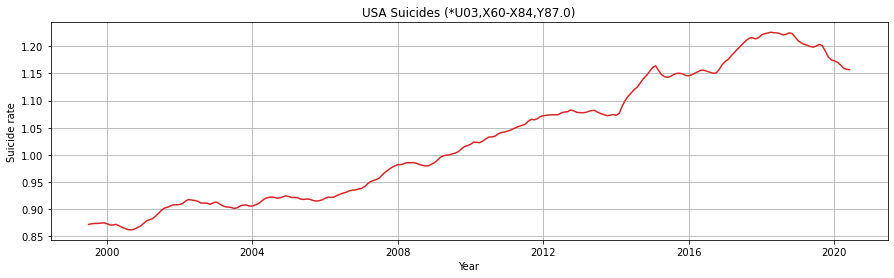

In [ ]:
plot(additive_decomposition.seasonal[:12])
plot(additive_decomposition.trend)

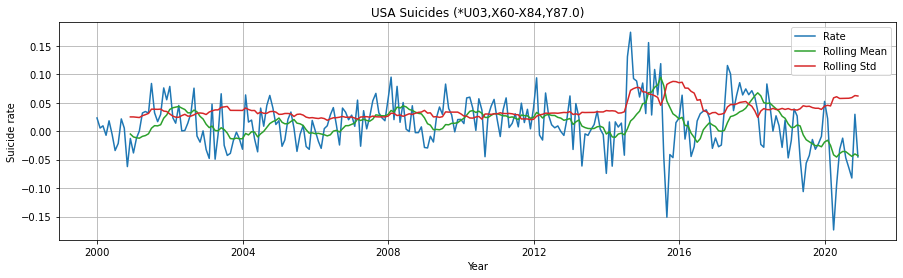

Results of Dickey-Fuller Test
Test Statistic                  -4.031260
p-value                          0.001255
#Lags Used                      12.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [ ]:
X_no_season = X_train.diff(periods = 12)
X_no_season.dropna(inplace=True)
X_no_season.index = pd.DatetimeIndex(X_no_season.index.values,
                               freq=X_no_season.index.inferred_freq)
stationarity_test(X_no_season)



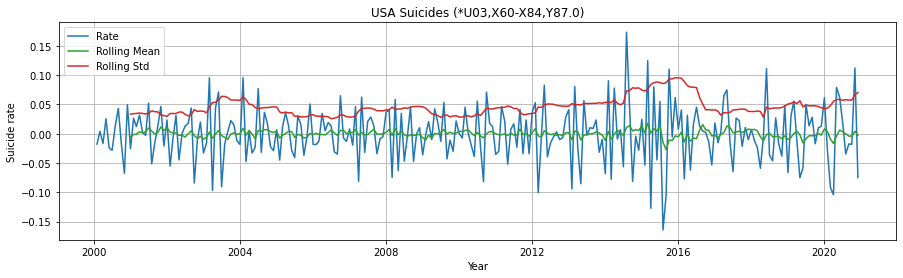

Results of Dickey-Fuller Test
Test Statistic                -6.122910e+00
p-value                        8.767611e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [ ]:
X_train_res_1 = X_no_season.diff(periods = 1)
X_train_res_1.dropna(inplace=True)
X_train_res_1.index = pd.DatetimeIndex(X_train_res_1.index.values,
                               freq=X_train_res_1.index.inferred_freq)
stationarity_test(X_train_res_1)

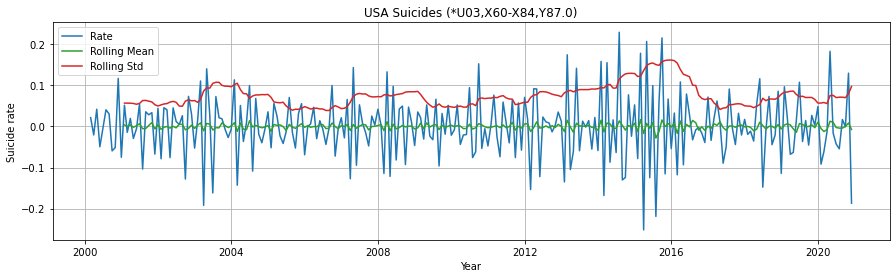

Results of Dickey-Fuller Test
Test Statistic                -7.234580e+00
p-value                        1.954612e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [ ]:
X_train_res_2 = X_train_res_1.diff(periods = 1)
X_train_res_2.dropna(inplace=True)
X_train_res_2.index = pd.DatetimeIndex(X_train_res_2.index.values,
                               freq=X_train_res_2.index.inferred_freq)
stationarity_test(X_train_res_2)

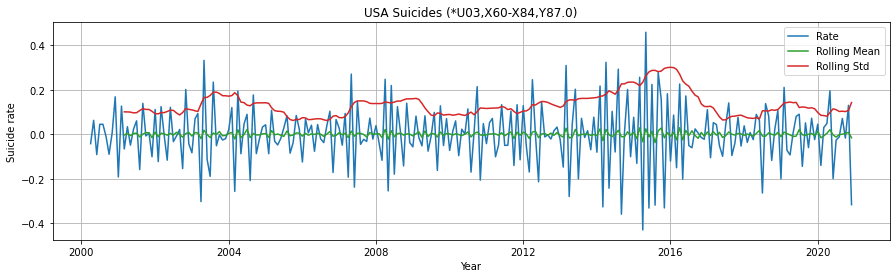

Results of Dickey-Fuller Test
Test Statistic                -8.522610e+00
p-value                        1.090371e-13
#Lags Used                     1.500000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


In [ ]:
X_train_res_3 = X_train_res_2.diff(periods = 1)
X_train_res_3.dropna(inplace=True)
X_train_res_3.index = pd.DatetimeIndex(X_train_res_3.index.values,
                               freq=X_train_res_3.index.inferred_freq)
stationarity_test(X_train_res_3)

Now we are going to try to model this as a stationary ARMA model. We will fit `X_train_res` which would be equivalent to fit the deseasonalized data with an ARIMA(p,1,q) model.

## PLOT asf,pacf

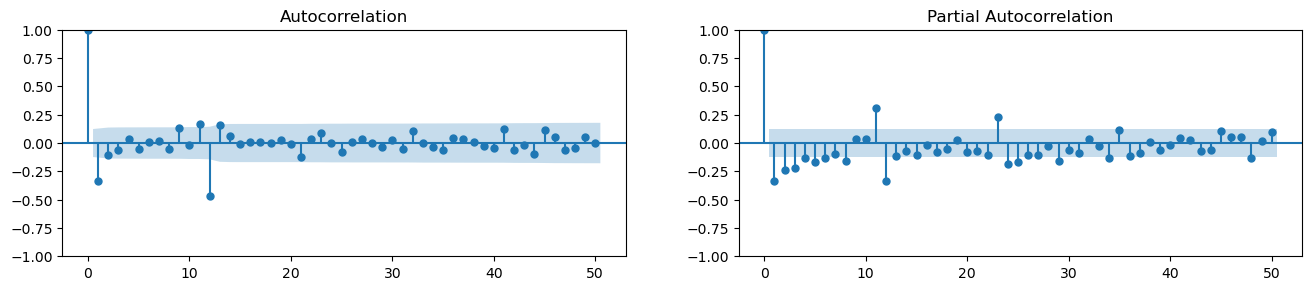

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(X_train_res_1['Deaths'].tolist(), lags=50, ax=axes[0]);
plot_pacf(X_train_res_1['Deaths'].tolist(), lags=50, ax=axes[1]);

As we can see in the plots, the Autocorrelation and the partial Autocorrelation are very similar. Most of the points are withtin in confidence interval when lag>2. This gives us certain confidence towards trying an MA(2) (More confident will be a MA(14)). Furthermore, we do not see a clear geometrical decay in the acf, which has a somehow indication that it may not be an AR(8) (More confident will be a MA(12)) process, even though we see that pacf might indicate it.

# Implementation of the model

In [ ]:
model1 = ARIMA(X_train_res_1, order = (0, 0, 2), trend="n")
results_MA = model1.fit()
print("AICC:", results_MA.aicc)
print(results_MA.summary())

AICC: -887.4055468450762
                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  251
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 446.751
Date:                Sun, 08 May 2022   AIC                           -887.503
Time:                        12:03:23   BIC                           -876.926
Sample:                    02-01-2000   HQIC                          -883.247
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5798      0.044    -13.280      0.000      -0.665      -0.494
ma.L2         -0.2254      0.044     -5.168      0.000      -0.311      -0.140
sigma2         0.0017      

In [ ]:
model1 = ARIMA(X_train_res_1, order = (0, 0, 14),  trend="n") 
results_MA = model1.fit()
print("AICC:", results_MA.aicc)
print(results_MA.summary())


AICC: -972.0161793130552
                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  251
Model:                ARIMA(0, 0, 14)   Log Likelihood                 502.029
Date:                Sun, 08 May 2022   AIC                           -974.059
Time:                        12:14:58   BIC                           -921.177
Sample:                    02-01-2000   HQIC                          -952.778
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5037      0.057     -8.816      0.000      -0.616      -0.392
ma.L2         -0.1701      0.077     -2.201      0.028      -0.322      -0.019
ma.L3         -0.0700      

c:\Users\alexg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
model1 = ARIMA(X_train_res_1, order = (8, 0, 0),  trend="n")
results_AR = model1.fit()
print("AICC:", results_AR.aicc)
print(results_AR.summary())

AICC: -879.6812489103298
                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  251
Model:                 ARIMA(8, 0, 0)   Log Likelihood                 449.214
Date:                Sun, 08 May 2022   AIC                           -880.428
Time:                        12:03:36   BIC                           -848.699
Sample:                    02-01-2000   HQIC                          -867.660
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5555      0.063     -8.759      0.000      -0.680      -0.431
ar.L2         -0.4885      0.088     -5.574      0.000      -0.660      -0.317
ar.L3         -0.4429      

In [ ]:
model1 = ARIMA(X_train_res_1, order = (12, 0, 0),  trend="n")
results_AR = model1.fit()
print("AICC:", results_AR.aicc)
print(results_AR.summary())

AICC: -927.7054221457861
                               SARIMAX Results                                
Dep. Variable:                 Deaths   No. Observations:                  251
Model:                ARIMA(12, 0, 0)   Log Likelihood                 477.621
Date:                Sun, 08 May 2022   AIC                           -929.241
Time:                        12:03:40   BIC                           -883.410
Sample:                    02-01-2000   HQIC                          -910.798
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4553      0.056     -8.182      0.000      -0.564      -0.346
ar.L2         -0.4286      0.081     -5.293      0.000      -0.587      -0.270
ar.L3         -0.3175      

c:\Users\alexg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
best_model_aicc, best_aicc, best_model_bic, best_bic = ARMA_grid_search(X_train_res_1, 20, 20)  

ARMA(0,1): AICC=-877.5230338469586, BIC=-870.5205150654691
ARMA(0,2): AICC=-887.4055468450762, BIC=-876.9263540195836
ARMA(0,3): AICC=-887.7775369268653, BIC=-873.8383267963544
ARMA(0,4): AICC=-885.9149113135547, BIC=-868.5325445770794
ARMA(0,5): AICC=-885.8074992526666, BIC=-864.9990439129579
ARMA(0,6): AICC=-883.7262551831535, BIC=-859.5089899590253
ARMA(0,7): AICC=-890.2183721744221, BIC=-862.6097899836819
ARMA(0,8): AICC=-888.4165102362301, BIC=-857.434321750849
ARMA(0,9): AICC=-889.333991208697, BIC=-854.9961284840457
ARMA(0,10): AICC=-901.6925091355882, BIC=-864.0171293155989
ARMA(0,11): AICC=-898.4755792970204, BIC=-857.481068397187
ARMA(0,12): AICC=-938.4794429290769, BIC=-894.1844196992666
ARMA(0,13): AICC=-964.3219010167218, BIC=-916.7452208858259
ARMA(0,14): AICC=-972.0161793130552, BIC=-921.1769384175677
ARMA(0,15): AICC=-969.1413366349708, BIC=-915.0588759336487
ARMA(0,16): AICC=-969.4444718209666, BIC=-912.1383812977863
ARMA(0,17): AICC=-966.890997116892, BIC=-906.3811200

In [ ]:
print(f"Best AICC: ARMA{best_model_aicc}; AICC={best_aicc}")
print(f"Best BIC: ARMA{best_model_bic}; AIC={best_bic}")

Best AICC: ARMA(0, 14); AICC=-972.0161793130552
Best BIC: ARMA(0, 14); AIC=-921.1769384175677


In [ ]:
p, q = best_model_aicc
print(f'Model used: ARMA({p}, {q})') 

best_arma_model = SARIMAX(X_train, order = (p, 1, q), seasonal_order=(0,1,0, 12),  trend="n")
results_best_arma = best_arma_model.fit()
print("AICC:", results_best_arma.aicc)
print(results_best_arma.summary())

Model used: ARMA(0, 14)
AICC: -971.865030413449
                                      SARIMAX Results                                       
Dep. Variable:                               Deaths   No. Observations:                  264
Model:             SARIMAX(0, 1, 14)x(0, 1, [], 12)   Log Likelihood                 501.954
Date:                              Sun, 08 May 2022   AIC                           -973.908
Time:                                      12:18:59   BIC                           -921.026
Sample:                                  01-01-1999   HQIC                          -952.627
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5010      0.056     -8.899      0

c:\Users\alexg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


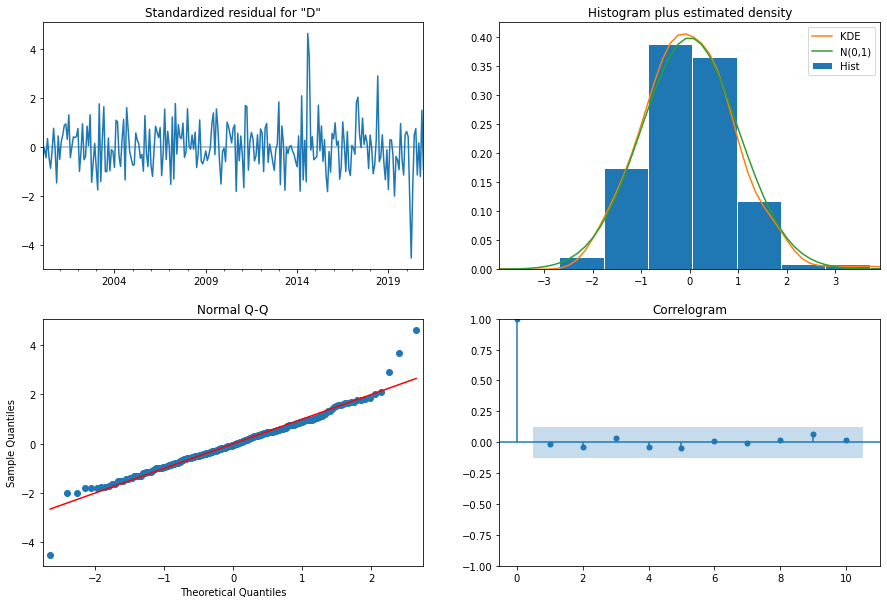

In [ ]:
results_best_arma.plot_diagnostics(figsize=(15,10));

In [ ]:
stepwise_fit = pm.auto_arima(X_train, start_p=1, start_q=1,
                             max_p=20, max_q=20, m=12, max_order=40,
                             start_P=0, max_P=0, D=1, start_Q=0, max_Q=0, 
                             seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise_fit=True,
                             information_criterion="aicc")  

Performing stepwise search to minimize aicc
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AICC=-898.462, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AICC=-842.537, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AICC=-897.900, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AICC=-884.063, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AICC=-822.913, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AICC=-898.627, Time=0.44 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AICC=-897.672, Time=0.05 sec
 ARIMA(3,0,1)(0,1,0)[12] intercept   : AICC=-896.705, Time=0.49 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AICC=-895.960, Time=0.28 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AICC=-898.394, Time=0.19 sec
 ARIMA(3,0,0)(0,1,0)[12] intercept   : AICC=-896.478, Time=0.28 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AICC=-894.423, Time=0.53 sec
 ARIMA(2,0,1)(0,1,0)[12]             : AICC=-897.845, Time=0.16 sec

Best model:  ARIMA(2,0,1)(0,1,0)[12] intercept
Total fit time: 3.019 se

In [ ]:
p, q = (2, 1)
print(f'Model used: ARMA({p}, {q})') 

best_arma_model_stepwise = SARIMAX(X_train, order = (p, 1, q), seasonal_order=(0,1,0, 12))
results_best_arma_stepwise = best_arma_model_stepwise.fit()
print("AICC:", results_best_arma_stepwise.aicc)
print(results_best_arma_stepwise.summary())

Model used: ARMA(2, 1)
AICC: -889.2699796225608
                                      SARIMAX Results                                      
Dep. Variable:                              Deaths   No. Observations:                  264
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                 448.716
Date:                             Sun, 08 May 2022   AIC                           -889.433
Time:                                     12:24:15   BIC                           -875.331
Sample:                                 01-01-1999   HQIC                          -883.758
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3900      0.059      6.628      0.000    

In [ ]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:              SARIMAX(11, 0, 0)   Log Likelihood               -1555.990
Date:                Fri, 06 May 2022   AIC                           3135.979
Time:                        20:54:13   BIC                           3178.237
Sample:                             0   HQIC                          3152.986
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3475      0.058    -23.396      0.000      -1.460      -1.235
ar.L2         -1.5863      0.111    -14.264      0.000      -1.804      -1.368
ar.L3         -1.6592      0.158    -10.498      0.000      -1.969      -1.349
ar.L4         -1.6010      0.180     -8.881      0.000      -1.954      -1.248
ar.L5         -1.4905      0.194     -7.690      0.000      -1.870      -1.111
ar.L6         -1.2836      0.204     -6.291      0.000      -1.684      -0.884
ar.L7         -1.0533      0.195     -5.398      0.000      -1.436      -0.671
ar.L8         -0.7966      0.178     -4.481      0.000      -1.145      -0.448
ar.L9         -0.3878      0.138     -2.810      0.005      -0.658      -0.117
ar.L10        -0.0576      0.102     -0.567      0.571      -0.257       0.142
ar.L11         0.2504      0.062      4.020      0.000       0.128       0.373
sigma2      1.453e+04   1144.952     12.691      0.000    1.23e+04    1.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.06
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.68   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

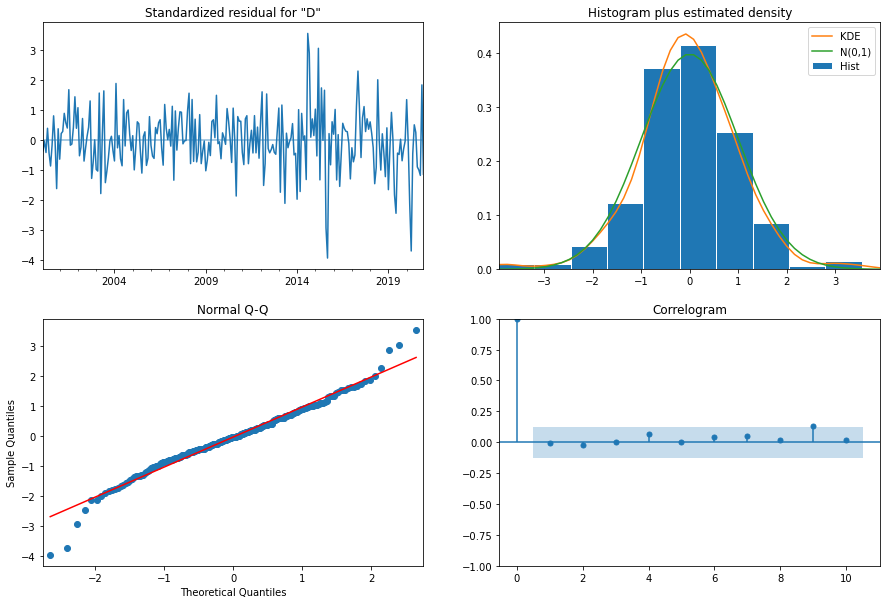

In [ ]:
results_best_arma_stepwise.plot_diagnostics(figsize=(15,10));

we are not going to use the stepwise ARMA. we are going to use the best subset one.

In [ ]:
stepwise_fit = pm.auto_arima(X_train, start_p=1, start_q=1,
                             max_p=20, max_q=20, m=12, max_order=40,
                             seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise_fit=True,
                             information_criterion="aicc")  

Performing stepwise search to minimize aicc
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AICC=-1018.345, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AICC=-647.534, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AICC=-909.240, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AICC=-816.983, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AICC=-649.542, Time=0.02 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AICC=-814.983, Time=0.33 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AICC=-951.151, Time=0.43 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AICC=-1017.110, Time=1.05 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AICC=-989.271, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AICC=-718.857, Time=0.06 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AICC=-882.761, Time=0.88 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AICC=-992.694, Time=0.88 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AICC=inf, Time=1.11 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AICC=-1011.625, Time=0.44 sec
 ARIMA

In [ ]:
print('Model used: SARIMA(1,1,1)x(1,0,1)_12') 

best_sarima_model_stepwise = SARIMAX(X_train, order = (1, 1, 1), seasonal_order=(1, 0, 1, 12))
results_best_sarima_stepwise = best_sarima_model_stepwise.fit()
print("AICC:", results_best_sarima_stepwise.aicc)
print(results_best_sarima_stepwise.summary())

Model used: SARIMA(1,1,1)x(1,0,1)_12
AICC: -1026.294911017779
                                     SARIMAX Results                                      
Dep. Variable:                             Deaths   No. Observations:                  264
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 518.264
Date:                            Sun, 08 May 2022   AIC                          -1026.528
Time:                                    12:30:21   BIC                          -1008.668
Sample:                                01-01-1999   HQIC                         -1019.351
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3314      0.064      5.148      0.0

c:\Users\alexg\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


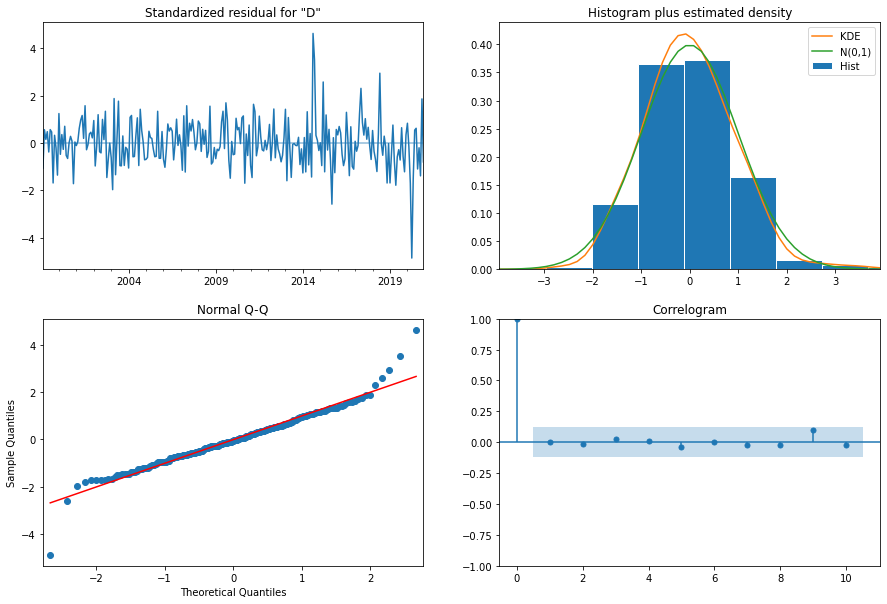

In [ ]:
results_best_sarima_stepwise.plot_diagnostics(figsize=(15,10));

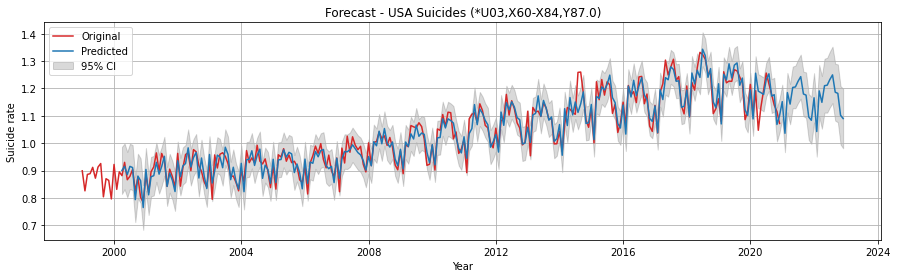

In [ ]:
available_months = X_train_res_1.shape[0]
months_to_predict = 3 * 12 # 3 years
plot_pred_(results_best_arma, end=available_months + months_to_predict)

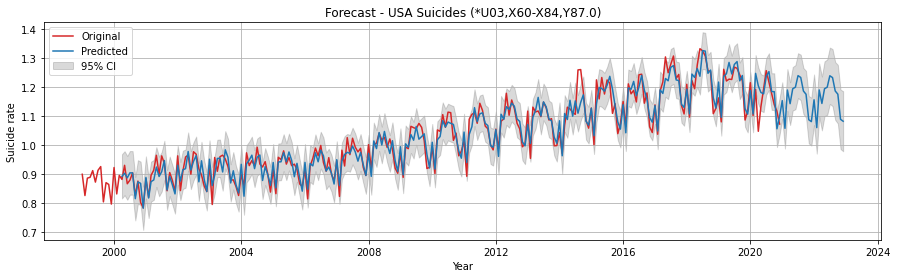

In [ ]:
plot_pred_(results_best_sarima_stepwise, end=available_months + months_to_predict)

So if we want best overall fit we could use the best SARIMA model, however if we would want to prioritize interpretability (at the cost of some performance) we could use the differentiating + ARMA model (or SARIMA replicating it)